<a href="https://colab.research.google.com/github/Chenzhang0329/StockPrice-Hybrid-Model-/blob/main/Final_Assignment_Main_Good_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# 1.0 Introduction

#2.0 Data Collection and Preprocessing


##2.1 Imports and Configurations

In [75]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

fatal: destination path 'StockPrice-Hybrid-Model-' already exists and is not an empty directory.


## 2.2 Setup of Data Collection Functions

In [77]:
# Retrieve financial info from active directory and feature engineer to scale the outcomes to the value of the mean sentiment scores *  count^2
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Caclulate Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

# Calculate Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calculate Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Rolling averages for 10,20,50, and 100 days  feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'])
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: pull_news() missing 1 required positional argument: 'ticker'


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [78]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1432 non-null   datetime64[ns]
 1   open       1432 non-null   float64       
 2   high       1432 non-null   float64       
 3   low        1432 non-null   float64       
 4   close      1432 non-null   float64       
 5   adj_close  1432 non-null   float64       
 6   volume     1432 non-null   int64         
 7   ticker     1432 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 89.6+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

#  3.0 Exploratory Data Analysis(EDA) and Data Cleaning
All data collection and initial prep is completed at this point.

In [79]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


## 3.1 Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [80]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)


goog = df_list[1].set_index('date').join(sentiment_dfs[1].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[1].mean())
msft = df_list[0].set_index('date').join(sentiment_dfs[0].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[0].mean())
amzn = df_list[2].set_index('date').join(sentiment_dfs[2].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[2].mean())
tesla = df_list[3].set_index('date').join(sentiment_dfs[3].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[3].mean())
nflx = df_list[4].set_index('date').join(sentiment_dfs[4].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[4].mean())

frames = [goog, msft, amzn, tesla, nflx]


<ipython-input-80-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-80-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-80-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

## 3.2 EDA to Explore Change in Stock Prices and Daily Headlines

In [82]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (10, 6))
frames = [goog, msft, amzn, tesla, nflx]
#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


KeyboardInterrupt: ignored

## 3.3 Scale Data and Configure Training/Test Datasets 

In [83]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1] # data for microsoft
data = data.drop(['ticker'],axis=1)
 
# features and target columns
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 

 # function to split  data 90% training-10% testing
def train_split(x1, y1, train_data):
  split = 0.9
  split_idx = int(np.ceil(len(X1)*split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = train_split(X1, y1, frames[1])
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1270, 10, 18) (1143, 10, 18) (127, 10, 18) (127, 1) (1143, 1)


# 4.0 Single Company Model Implementation

This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## 4.1 Build  & Validate the LSTM Model on Microsoft Stock
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [84]:
#LSTM Framework for MSFT
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]

#validating the training
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


36/36 [==============================] - 1s 7ms/step - loss: 9.4326e-04 - mean_squared_error: 9.4326e-04
[0.0009432631777599454, 0.0009432631777599454]
{'n_hidden': 0, 'neurons_visible': 78, 'activate1': 'sigmoid', 'dropout1': 0.7, 'neurons_hidden1': 50, 'dropout2': 0.4, 'neurons_hidden2': 30, 'dropout3': 0.7, 'neurons_hidden3': 30}


##4.2 LSTM Model Testing

### 4.2.2 Evaluate LSTM Model Success on MSFT Test Data

In [85]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  return model.predict(trainset)


4/4 [==============================] - 1s 8ms/step


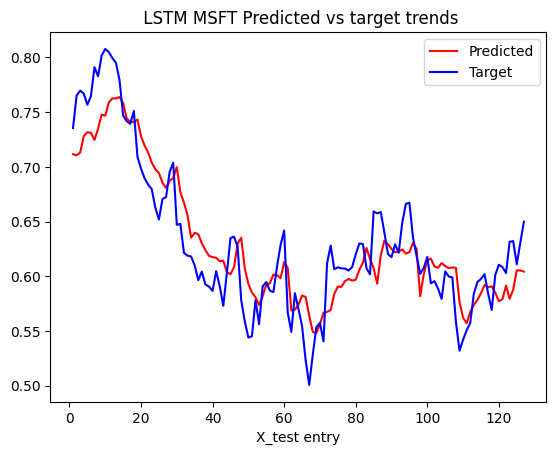

In [86]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_test)
LSTM_MSFT_test.shape

import matplotlib.pyplot as plt
x=np.arange(1,len(y_test)+1, 1)
plt.plot(x,LSTM_MSFT_test.flatten(), "r", label= "Predicted")
plt.plot(x,y_test, "b", label= "Target")

plt.title(" LSTM MSFT Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

### 4.2.1 Format Test Data to Reflect Training Data for Google Stock

In [87]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(test_ft))

In [88]:
#test LSTM model using X_train for GOOG
LSTM_GOOG_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', google_ft)
LSTM_GOOG_yhat.shape

40/40 [==============================] - 1s 6ms/step


(1270, 1)

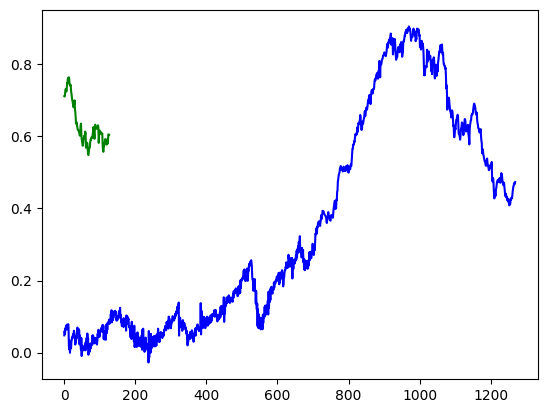

In [89]:
# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_test, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()




##4.3 Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [90]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [91]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

### 4.3.1 Forecasting with Prophet

In [93]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

In [94]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]
MSFT_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/rxa8ire5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/du_44ypy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18361', 'data', 'file=/tmp/tmponyuemge/rxa8ire5.json', 'init=/tmp/tmponyuemge/du_44ypy.json', 'output', 'file=/tmp/tmponyuemge/prophet_modelojcrt9qx/prophet_model-20230413165035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/09qinl6s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/zwrqc3fa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84414', 'data', 'file=/tmp/tmponyuemge/09qinl6s.json', 'init=/tmp/tmponyuemge/zwrqc3fa.json', 'output', 'file=/tmp/tmponyuemge/prophet_modelo88t5qsv/prophet_model-20230413165039.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:50:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/6f4mz4at.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/h_vql36m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,73.970595
1,2017-12-19,68.597337
2,2017-12-20,60.279245
3,2017-12-21,49.091784
4,2017-12-22,34.894607


In [95]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]
Google_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/9rtn0mu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/ugha96m6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91375', 'data', 'file=/tmp/tmponyuemge/9rtn0mu5.json', 'init=/tmp/tmponyuemge/ugha96m6.json', 'output', 'file=/tmp/tmponyuemge/prophet_modelap3uldpr/prophet_model-20230413165635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/3pup0oxn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/vo9s7qs1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26093', 'data', 'file=/tmp/tmponyuemge/3pup0oxn.json', 'init=/tmp/tmponyuemge/vo9s7qs1.json', 'output', 'file=/tmp/tmponyuemge/prophet_model6ta065f_/prophet_model-20230413165637.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/7wlxynzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/9aliux26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,53.406188
1,2017-12-19,53.607782
2,2017-12-20,53.609407
3,2017-12-21,53.306160
4,2017-12-22,52.961331


In [96]:
def prep_prophet(prophet_pred, data1):
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2018-01-01':'2023-02-01', 'yhat']
  return returned

goog_data = prep_prophet(Google_train_data, frames[0])[10:]
msft_train_data = prep_prophet(MSFT_train_data, frames[1])[10:1153]
msft_test_data = prep_prophet(MSFT_train_data, frames[1])[1153:]


##4.4 Hybrid Model 

 ### 4.4.1 Define Training Data Using Ouputs from Standalone Models MSFT

In [97]:
#creating y_hybrid from y_train of the LSTM model
print(y_train.shape)
y_hybrid= y_train
print(y_train.shape, y_hybrid.shape)
print(goog_data.shape)

(1143, 1)
(1143, 1) (1143, 1)
(1270,)


In [98]:
#verifying that outputs from both the LSTM and Prohet models match in size
LSTM_MSFT_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_train)
print ("LSTM:", LSTM_MSFT_yhat.shape,"\n","Prophet:", msft_train_data.shape)

#merging the the outcomes from the LSTM model and the Prophet model

msft_hybrid = { 'LSTM':LSTM_MSFT_yhat.flatten(), 'prophet':np.array(msft_train_data), }
msft_hybrid_df = pd.DataFrame(msft_hybrid)

#scaling the MSFT_PROPHET column
scaler2 = MinMaxScaler()
msft_hybrid_df['prophet'] = scaler2.fit_transform(msft_hybrid_df[['prophet']])

#Defining the data for the hybrid training
X2_ft = np.array(msft_hybrid_df)
print("y_hybrid", y_hybrid.shape)

X_train2,y_train2 = lstm_split(msft_hybrid_df,y_hybrid,len(msft_hybrid_df))


36/36 [==============================] - 0s 5ms/step
LSTM: (1143, 1) 
 Prophet: (1143,)
y_hybrid (1143, 1)


In [99]:
#LSTM Framework for the hybrid model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
import keras_tuner


#Hybrid model architecture and training
LR = 0.01
EPOCH = 300
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 98, activation = "sigmoid", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = False))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

hybrid_history = hybrid.fit(X_train2, y_train2, epochs = EPOCH, batch_size = BATCH, callbacks = [Early_stop])

hybrid_history.model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

Epoch 1/300


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


48/48 [==============================] - 3s 10ms/step - loss: 0.2259 - mae: 0.3590
Epoch 2/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0644 - mae: 0.2049
Epoch 3/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0408 - mae: 0.1620
Epoch 4/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0215 - mae: 0.1169
Epoch 5/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0176 - mae: 0.1049
Epoch 6/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0136 - mae: 0.0915
Epoch 7/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0112 - mae: 0.0832
Epoch 8/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0093 - mae: 0.0766
Epoch 9/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0091 - mae: 0.0722
Epoch 10/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0076 - mae: 0.0668
Epoch 11/300
48/48 [==============================] - 0s 10ms/ste

###4.4.2 LOSS and MAE

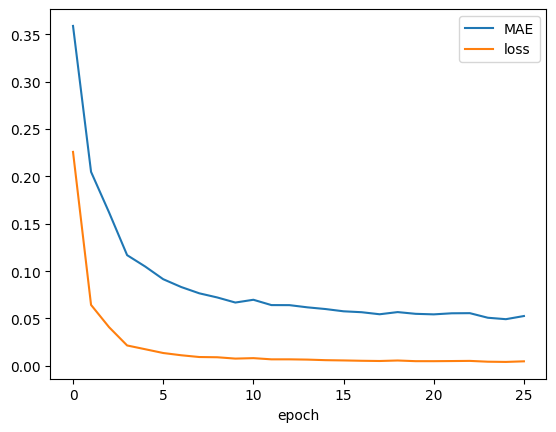

In [100]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4.4.3 Comparing output of LSTM MSFT and Hybrid MSFT 

###4.4.4 Hybrid Model Testing on GOOG

In [101]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  data_dict = {}
  scaler = MinMaxScaler()
  data_dict['LSTM'] = lstm_pred.flatten()
  data_dict['prophet'] = np.array(prophet_pred)
  hybrid_test_data = pd.DataFrame(data_dict)
  hybrid_test_data['prophet'] = scaler.fit_transform(hybrid_test_data[['prophet']])
  return hybrid_test_data

In [102]:
from keras.models import load_model
MSFT_test_hybrid = merge_predictions(LSTM_MSFT_test, msft_test_data)
MSFT_x_test, MSFT_y_test = lstm_split(MSFT_test_hybrid, y_test, len(MSFT_test_hybrid))
MSFT_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', MSFT_x_test)

4/4 [==============================] - 0s 5ms/step


In [103]:
print(LSTM_GOOG_yhat.shape,goog_data.shape)
GOOG_test_hybrid= merge_predictions(LSTM_GOOG_yhat, goog_data)
GOOG_x_test, GOOG_y_test = lstm_split(GOOG_test_hybrid,google_target,len(GOOG_test_hybrid))
GOOG_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', GOOG_x_test)


(1270, 1) (1270,)
40/40 [==============================] - 0s 4ms/step


In [104]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    rmse = tf.keras.metrics.RootMeanSquaredError()
    rmse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    print(f"the root mean square error of the predictions is {rmse.result().numpy()}, and the mean absolute error of the predictions is {mae.result().numpy()}")
    return rmse.result().numpy(), mae.result().numpy()

In [119]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(msft_hybrid_df,y_hybrid)
linear_predictions_GOOG = linear_model.predict(GOOG_test_hybrid)
linear_predictions_MSFT = linear_model.predict(MSFT_test_hybrid)

AttributeError: ignored

###4.4.5 Predicted vs Actual Price

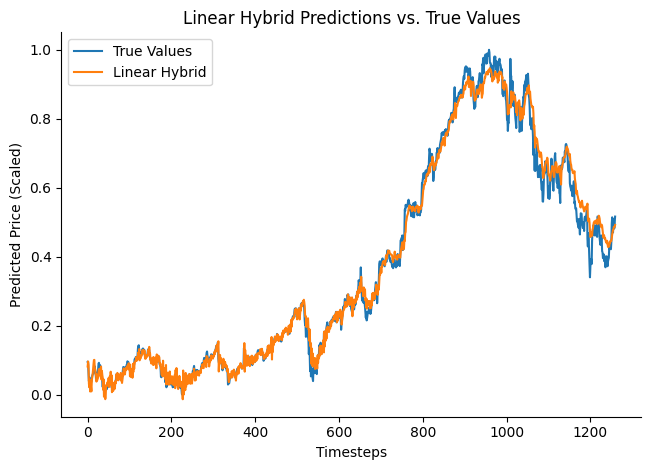

In [106]:

plt.plot(GOOG_y_test, label="True Values")
plt.plot(linear_predictions_GOOG[10:], label="Linear Hybrid")
#plt.plot(GOOG_predictions, label="LSTM Hybrid")
plt.xlabel("Timesteps")
plt.ylabel("Predicted Price (Scaled)")
plt.title('Linear Hybrid Predictions vs. True Values')
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

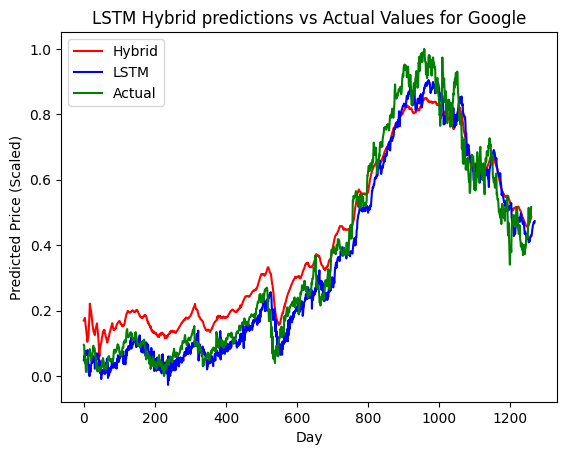

In [107]:
import matplotlib.pyplot as plt
x=np.arange(1,len(GOOG_y_test)+1, 1)
plt.plot(GOOG_predictions.flatten(), "r", label= "Hybrid")
plt.plot(LSTM_GOOG_yhat, "b", label= "LSTM")
plt.plot(GOOG_y_test, "g", label= "Actual")

plt.title("LSTM Hybrid predictions vs Actual Values for Google")
plt.xlabel('Day')
plt.ylabel("Predicted Price (Scaled)")
plt.legend()
plt.show()

## Return Predictions to Original Scale for Final Analysis

In [ ]:
GOOG_scaler = 
MSFT_scaler = 

#5.0 Multiple Company Model

## 5.1 Generate Sub-models

In [108]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in range(len(list_of_df)):
    scaler = MinMaxScaler()
    data = list_of_df[i]
    score = data['score']
    target = scaler.fit_transform(data[['target']])
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    for col in training.columns:
      training[col] = scaler.fit_transform(training[[col]])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, len(training))
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames[1:])
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/sub_models/'+tick+'_lstm.h5')


Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


52/53 [============================>.] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.0190

53/53 [==============================] - 3s 15ms/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 2/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 11ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 4/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 7/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 8/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 11/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 12/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 13/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 14/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 15/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 16/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 18/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 19/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 21/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 23/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 24/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 25/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 26/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 27/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 28/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 29/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 30/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 33/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 34/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 35/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 36/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 41/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 42/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 44/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 47/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 48/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 50/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 53/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 54/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 55/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 57/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 58/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 60/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 61/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 62/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 63/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 64/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 65/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 66/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 67/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 68/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 69/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 70/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 71/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 73/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 75/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 76/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 77/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 78/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 79/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 80/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 81/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 82/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 83/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 84/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 86/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 87/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 88/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 89/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 90/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 91/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 93/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 94/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 95/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 98/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 99/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 100/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 101/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 102/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 103/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 104/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 105/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 106/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 107/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 108/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 109/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 110/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 111/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 112/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 113/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 114/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 115/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 117/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 118/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 119/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 120/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 122/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

53/53 [==============================] - 1s 14ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 125/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 126/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 127/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 130/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 131/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 132/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 133/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 134/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 135/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 136/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 137/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 138/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 139/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 140/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 141/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 142/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 143/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 144/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 147/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 148/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 149/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 150/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 151/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 152/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 153/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 154/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 155/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 156/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 157/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 158/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 159/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 160/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 161/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 163/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 165/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 166/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 167/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 14ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 168/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 169/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 171/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 14ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 172/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 173/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 174/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 176/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 177/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 178/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 180/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 182/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 183/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 184/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 186/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 187/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 188/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 189/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 190/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 191/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 192/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 193/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 194/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 195/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 196/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 198/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 199/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 200/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 1/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0191 - mean_squared_error: 0.0191

53/53 [==============================] - 2s 10ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 2/200
52/53 [============================>.] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 10ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 3/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

53/53 [==============================] - 1s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 4/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 10ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 5/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 10ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 6/200
52/53 [============================>.] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 10ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 7/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 11ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 8/200
52/53 [============================>.] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 10ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 10/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

53/53 [==============================] - 1s 10ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 13/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 14ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 15ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 15/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 16/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 17/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 19/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 21/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 22/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 23/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 24/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 25/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 26/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 27/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 28/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 29/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 30/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 31/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 32/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 33/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 34/200
52/53 [============================>.] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 36/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 39/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 40/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 41/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 42/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 43/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 44/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 45/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 47/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 48/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 49/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 50/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 52/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 53/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 54/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 55/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 57/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 58/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 60/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 13ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 61/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 62/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 64/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 66/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 67/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 68/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 69/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 70/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 71/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 72/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 74/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 75/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 76/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 77/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 78/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 79/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 80/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 81/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 82/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 83/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 84/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 85/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 86/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 88/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 89/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 91/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 92/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 93/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 96/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 97/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 98/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 99/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 100/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 103/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 104/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 105/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 106/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 107/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 109/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 110/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 111/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 112/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 13ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 113/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 114/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 115/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 116/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 117/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 118/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 119/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 121/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 122/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 123/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 124/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 125/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 127/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 130/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 131/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 132/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 133/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 134/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 135/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 136/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 137/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 138/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 139/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 141/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 142/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 143/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 144/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 145/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 146/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 148/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 149/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 150/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 151/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 153/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 154/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 155/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 156/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 157/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 159/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 160/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 162/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 163/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 164/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 165/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 168/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 169/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 170/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 171/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 173/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 174/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 175/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 176/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 177/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 3s 51ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 178/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 180/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 181/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 182/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 183/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 2s 39ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 184/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 19ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 185/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 186/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 187/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 188/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 189/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 191/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 192/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 193/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 196/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 197/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 198/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 200/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 1/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0191 - mean_squared_error: 0.0191

53/53 [==============================] - 2s 10ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 3/200
53/53 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 11ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 4/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 7/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 14ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 8/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 10/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 12/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 13/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 14/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 15/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 16/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 17/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 18/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 19/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 20/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 21/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 22/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 23/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 24/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 25/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 26/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 27/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 28/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 30/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 31/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 34/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 36/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 37/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 39/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 41/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 42/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 43/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 44/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 45/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 47/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 48/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 49/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 50/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 53/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 55/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 57/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 58/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 59/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 60/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 61/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 62/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 63/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 64/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 65/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 66/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 68/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 69/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 70/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 71/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 73/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 74/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 75/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 77/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 78/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 80/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 81/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 82/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 83/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 84/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 86/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 87/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 88/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 89/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 91/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 93/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 94/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 96/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 98/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 99/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 100/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 15ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 102/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 103/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 104/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 105/200
52/53 [============================>.] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

53/53 [==============================] - 1s 11ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 106/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 107/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 109/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 110/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 111/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 112/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 113/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 114/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 115/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 116/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 117/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 118/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 119/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 121/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 122/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 123/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 125/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 15ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 126/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 127/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 16ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 129/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 130/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 131/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 132/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 133/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 134/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 135/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 136/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 137/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 138/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 139/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 140/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 141/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 142/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 143/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 144/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 146/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 147/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 148/200
52/53 [============================>.] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 149/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 150/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 151/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 16ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 153/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 154/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 155/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 156/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 157/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 158/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 159/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 160/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 161/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 162/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 163/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 164/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 165/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 166/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 168/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 169/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

53/53 [==============================] - 1s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 170/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 171/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 172/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 173/200
52/53 [============================>.] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 174/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 176/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 177/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 178/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 179/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 180/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

53/53 [==============================] - 1s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 181/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 182/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 184/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 185/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 187/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 188/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 189/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 191/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 192/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 193/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 194/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 196/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 197/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 15ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 198/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 16ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 200/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 1/200
52/53 [============================>.] - ETA: 0s - loss: 0.0203 - mean_squared_error: 0.0203

53/53 [==============================] - 2s 11ms/step - loss: 0.0200 - mean_squared_error: 0.0200
Epoch 2/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

53/53 [==============================] - 1s 12ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 3/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 12ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 6/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 7/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 8/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 10/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 13/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 14/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 15ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 16/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 17/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 18/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 19/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 20/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 21/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 22/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 23/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 24/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 25/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 26/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 27/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 28/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 30/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 31/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 32/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 33/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 34/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 35/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 36/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 37/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 39/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 41/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 15ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 42/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 43/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 45/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 47/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 48/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 49/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 50/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 51/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 52/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 53/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 54/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 55/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 57/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 58/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 59/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 60/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 61/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 62/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 63/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 64/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 66/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 67/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 68/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 69/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 70/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 71/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 73/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 74/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 76/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 77/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 78/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 79/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 80/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 81/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 82/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 83/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 84/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 85/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 86/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 87/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 88/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 89/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 91/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 92/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 93/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 96/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 97/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 98/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 99/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 101/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 102/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 103/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 104/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 105/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 106/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 107/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 109/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 110/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 111/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 112/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 113/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 114/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 115/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 116/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 117/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 118/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 119/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 121/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 122/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 123/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 124/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 125/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 126/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 127/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 128/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 129/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 130/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 131/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 132/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 133/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 135/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 136/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 18ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 137/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 138/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 139/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 140/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 141/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 142/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 143/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 144/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 145/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 148/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 149/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 151/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 153/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 154/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 155/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 156/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 157/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 158/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 159/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 160/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 25ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 161/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 163/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 166/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 167/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 168/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 169/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 171/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 172/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 177/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 178/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 179/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 180/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 181/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 182/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 184/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 187/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 188/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 189/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 190/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 191/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 192/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 193/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 195/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 198/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 199/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 200/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047


### 5.1.1 Configure Hybrid Training Set and Train Hybrid Model

In [109]:
import os

def hybrid_train(direct, ticker_list, hybrid_train, prophet, targets):
    preds_dict = {}
    path = direct
    scaler = MinMaxScaler()
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    preds_df['prophet'] = np.array(prophet)
    preds_df['prophet'] = scaler.fit_transform(preds_df[['prophet']])
    x1,y1 = lstm_split(preds_df, targets, len(preds_df))
    return x1, y1, preds_df, targets

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data, targets, preds_df, training_y =  hybrid_train('/content/StockPrice-Hybrid-Model-/sub_models/', ticker_list, X_train, msft_train_data, y_hybrid) 
hybrid_expanded = multiple_models(hybrid_training_data, targets)

36/36 [==============================] - 0s 4ms/step
Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


44/48 [==========================>...] - ETA: 0s - loss: 0.0220 - mean_squared_error: 0.0220

48/48 [==============================] - 2s 9ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 2/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

48/48 [==============================] - 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 3/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 4/200
48/48 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

48/48 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 5/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 6/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

48/48 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 7/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

48/48 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 8/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

48/48 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 9/200
47/48 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

48/48 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 10/200
47/48 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 11/200
47/48 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 12/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 13/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 14/200
47/48 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 1s 15ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 15/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 16/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 17/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

48/48 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 18/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 19/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 20/200
47/48 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 21/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 22/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 23/200
47/48 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 24/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 25/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 26/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 27/200
48/48 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 28/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 29/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 30/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 31/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 32/200
47/48 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 33/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 34/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 35/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 36/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 37/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 38/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 39/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 40/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 41/200
48/48 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 42/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 43/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 44/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 45/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 46/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 47/200
48/48 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 48/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 49/200
47/48 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 50/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 51/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 52/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 53/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 55/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 57/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 58/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 59/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 60/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 61/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 62/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 63/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 64/200
47/48 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 65/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 66/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 67/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 68/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 69/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 70/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 71/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 72/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 73/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 74/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 75/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 76/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 77/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 78/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 79/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 80/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 81/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 82/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 83/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 84/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 85/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 86/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 87/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 88/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 89/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 90/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 15ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 91/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 92/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 93/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 94/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 95/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 96/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 97/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 98/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 99/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 100/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 101/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 102/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 103/200
47/48 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 104/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 105/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 106/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 107/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 108/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 109/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 110/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 111/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 112/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 113/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 114/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 115/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 116/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 117/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 118/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 119/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 120/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 121/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 122/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 123/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 124/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 125/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 126/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 127/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 128/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 129/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 130/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 131/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 132/200
47/48 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 133/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 134/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 135/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 136/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 137/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 138/200
48/48 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 139/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 140/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 141/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 142/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 143/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 144/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 145/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 146/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 147/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 148/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 149/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 150/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 151/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 152/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 153/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 154/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 155/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 156/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 157/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 158/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 159/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 160/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 161/200
47/48 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 162/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 163/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 164/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 165/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 166/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 167/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 168/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 169/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 170/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 171/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 172/200
47/48 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 173/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 174/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 175/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 176/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 177/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 178/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 179/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 180/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 181/200
48/48 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 182/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 183/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 184/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 185/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 186/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 187/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 188/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 189/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 190/200
48/48 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 191/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 192/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 193/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 194/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 195/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 196/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 197/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 198/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 199/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 200/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036


In [110]:
hybrid_expanded.save('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')

### 5.1.2 Test the Expanded Model

In [111]:
from os import listdir
hybrid_expanded = load_model('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')
google_test = {}
microsoft_test = {}
path = '/content/StockPrice-Hybrid-Model-/sub_models/'
for num, model in enumerate(os.listdir(path)):
  scaler = MinMaxScaler()
  model = load_model(path+model)
  goog_preds = model.predict(google_ft).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

google_test['prophet'] = np.array(goog_data)
google_test['prophet'] = scaler.fit_transform(google_test[['prophet']])
microsoft_test['prophet'] = np.array(msft_test_data)
microsoft_test['prophet'] = scaler.fit_transform(microsoft_test[['prophet']])

goog_x, goog_y = lstm_split(google_test, google_target, len(google_test))
msft_x, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))


4/4 [==============================] - 0s 5ms/step


In [112]:
goog_predictions = hybrid_expanded.predict(goog_x)
msft_predictions = hybrid_expanded.predict(msft_x)

4/4 [==============================] - 0s 4ms/step


In [113]:
linear_model = LinearRegression()
linear_model.fit(preds_df,training_y)
linear_ex_goog = linear_model.predict(google_test)
linear_ex_msft = linear_model.predict(microsoft_test)
mse, mae = compute_metrics(google_target, linear_ex_goog)
print(mse)

the root mean square error of the predictions is 0.02931579016149044, and the mean absolute error of the predictions is 0.024102484807372093
0.02931579


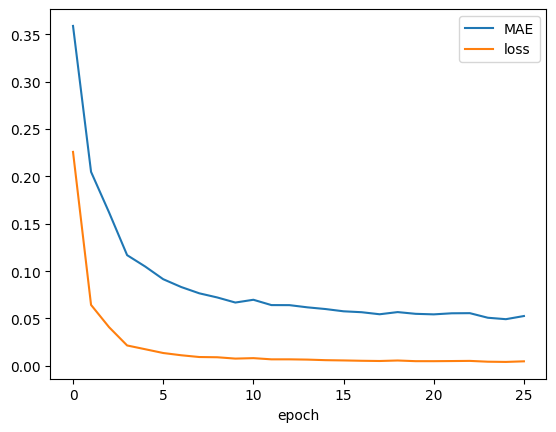

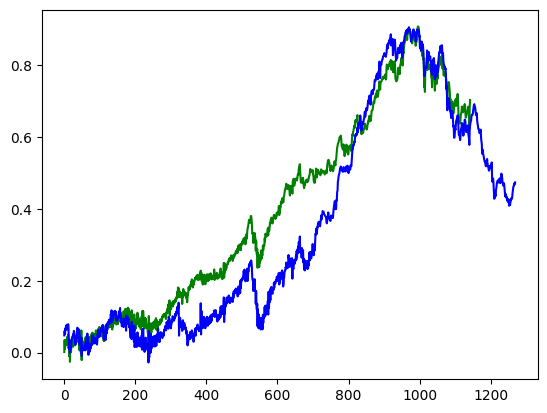

In [114]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# compare LSTM on trained on MSFT on predictions for Google
fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_yhat, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()

In [115]:
#prepare all predictions
#lstm
print('single LSTM model')
msft_lstm_mse, msft_lstm_mae = compute_metrics(y_test, LSTM_MSFT_test)
goog_lstm_mse, goog_lstm_mae = compute_metrics(google_target, LSTM_GOOG_yhat)

print('single hybrid model')
#single hybrid
msft_single_mse, msft_single_mae = compute_metrics(MSFT_y_test, MSFT_predictions)
goog_single_mse, goog_single_mae = compute_metrics(GOOG_y_test, GOOG_predictions)

print('single linear model')
#Single linear hybrid
msft_sing_linear_mse, msft_sing_linear_mae = compute_metrics(y_test, linear_predictions_MSFT)
goog_linear_mse, goog_linear_mae = compute_metrics(google_target, linear_predictions_GOOG)

print('expanded hybrid model')
#expanded_hybrid
msft_expanded_mse, msft_expanded_mae = compute_metrics(msft_y, msft_predictions)
goog_expanded_mse, goog_expanded_mae = compute_metrics(goog_y, goog_predictions)

print('expanded linear model')
#Expanded linear hybrid
msft_exlin_mse, msft_exlin_mae = compute_metrics(y_test, linear_ex_msft)
goog_exlin_mse, goog_exlin_mae = compute_metrics(google_target, linear_ex_goog)

single LSTM model
the root mean square error of the predictions is 0.030548470094799995, and the mean absolute error of the predictions is 0.02526312693953514
the root mean square error of the predictions is 0.03667834401130676, and the mean absolute error of the predictions is 0.0285269096493721
single hybrid model
the root mean square error of the predictions is 0.1275772601366043, and the mean absolute error of the predictions is 0.1040276437997818
the root mean square error of the predictions is 0.07908383756875992, and the mean absolute error of the predictions is 0.07163264602422714
single linear model
the root mean square error of the predictions is 0.04445784166455269, and the mean absolute error of the predictions is 0.03744694963097572
the root mean square error of the predictions is 0.030106578022241592, and the mean absolute error of the predictions is 0.021243618801236153
expanded hybrid model
the root mean square error of the predictions is 0.04168417304754257, and the me

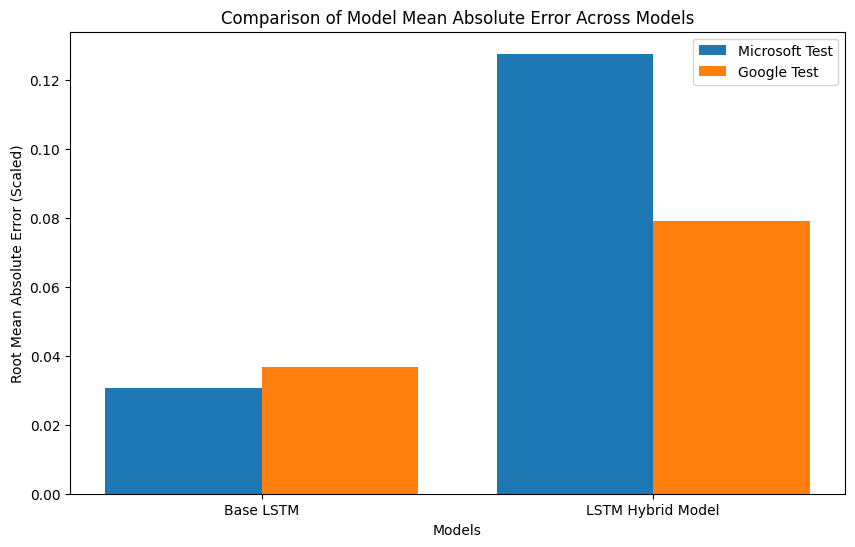

In [116]:
x = ['Base LSTM', 'LSTM Hybrid Model']
msft = [msft_lstm_mse, msft_single_mse]
goog = [goog_lstm_mse, goog_single_mse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')
plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Absolute Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.legend()
plt.show()

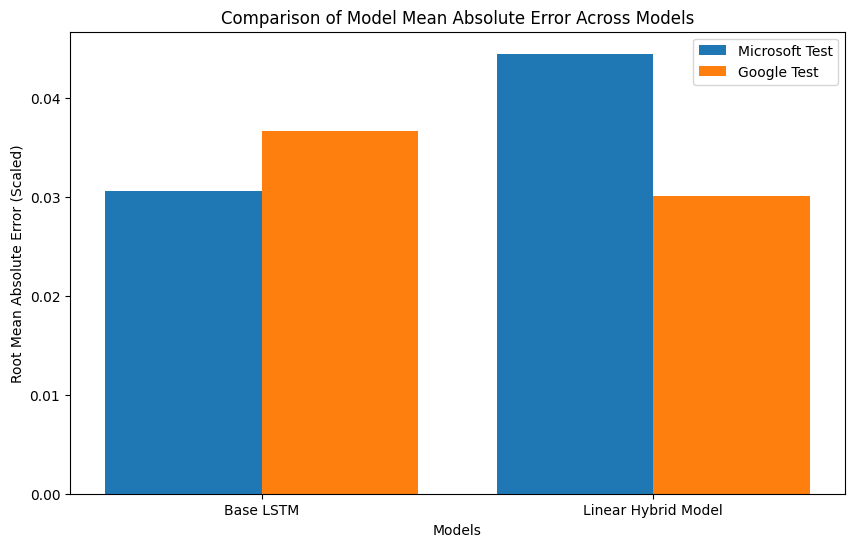

In [117]:
x = ['Base LSTM', 'Linear Hybrid Model']
msft = [msft_lstm_mse, msft_sing_linear_mse]
goog = [goog_lstm_mse, goog_linear_mse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')
plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Absolute Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.legend()
plt.show()

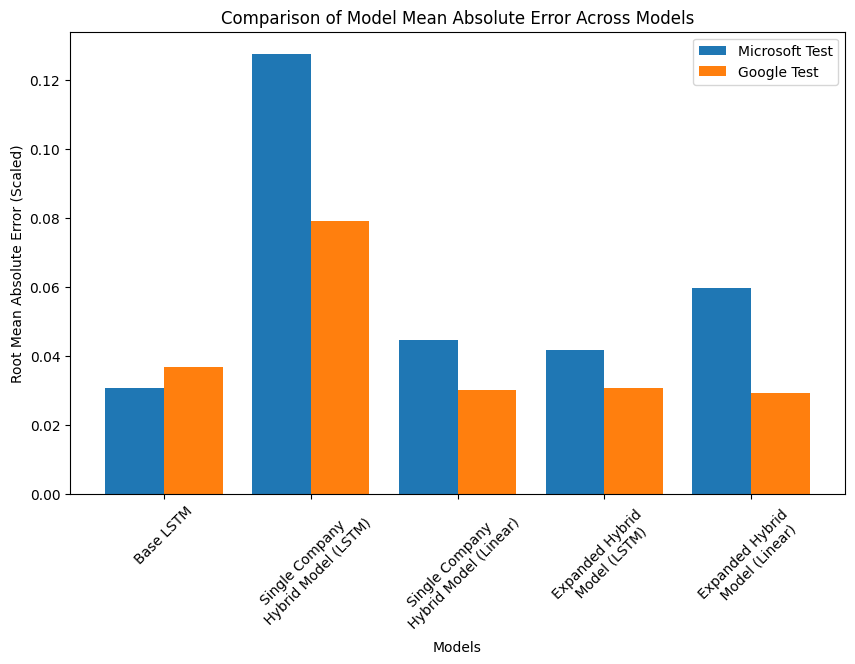

In [118]:
import seaborn as sns
x = ['Base LSTM', 'Single Company \n Hybrid Model (LSTM)', 'Single Company \n Hybrid Model (Linear)', "Expanded Hybrid \n Model (LSTM)", "Expanded Hybrid \n Model (Linear)"]
msft = [msft_lstm_mse, msft_single_mse, msft_sing_linear_mse, msft_expanded_mse, msft_exlin_mse]
goog = [goog_lstm_mse, goog_single_mse, goog_linear_mse, goog_expanded_mse, goog_exlin_mse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')

plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Absolute Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.xticks(rotation = 45)
plt.legend()
plt.show()